In [2]:
import geopandas as gpd
from geodatasets import get_path
import geodatasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from shapely.geometry import Point
import plotly_express as px

world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
world = world.to_crs("EPSG:3338")

crab_df = pd.read_csv("mfsnowcrab.csv")
print(crab_df.dtypes)
crab_df.tail()

id                       int64
latitude               float64
longitude              float64
year                     int64
name                    object
sex                     object
bottom_depth             int64
surface_temperature    float64
bottom_temperature     float64
haul                     int64
cpue                     int64
dtype: object


,id,latitude,longitude,year,name,sex,bottom_depth,surface_temperature,bottom_temperature,haul,cpue
17922,167236,59.01374,-169.17953,2018,snow crab,female,54,6.9,4.2,94,140
17923,167235,58.70274,-173.01226,2018,snow crab,female,113,7.6,3.5,150,435
17924,167234,58.67382,-172.36066,2018,snow crab,female,101,7.5,3.4,159,1880
17925,167233,58.66392,-171.72005,2018,snow crab,female,93,7.9,3.4,135,598
17926,167232,58.66620,-171.08591,2018,snow crab,female,82,7.7,3.6,142,35198


In [3]:
crab_df['geometry'] = crab_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
crab_gdf = gpd.GeoDataFrame(crab_df, geometry='geometry')


In [4]:
total_length = len(crab_df)
print(total_length)

17927


In [5]:
numeric_cols = ['latitude', 'longitude','bottom_depth', 'surface_temperature', 'bottom_temperature', 'haul', 'cpue']
for col in numeric_cols:
    crab_df[col] = pd.to_numeric(crab_df[col], errors='coerce')

In [6]:
crab_df.dtypes

id                       int64
latitude               float64
longitude              float64
year                     int64
name                    object
sex                     object
bottom_depth             int64
surface_temperature    float64
bottom_temperature     float64
haul                     int64
cpue                     int64
geometry                object
dtype: object

In [7]:
print('Numeric Column Overall Means')
print(crab_df[numeric_cols].mean())
print("\n")
print('Numeric Columns Missing Value Percentage')
print(crab_df[numeric_cols].isna().mean())

Numeric Column Overall Means
latitude                  58.529967
longitude               -170.670173
bottom_depth              90.006192
surface_temperature        7.124287
bottom_temperature         1.802226
haul                     123.805991
cpue                   32875.689240
dtype: float64


Numeric Columns Missing Value Percentage
latitude               0.0
longitude              0.0
bottom_depth           0.0
surface_temperature    0.0
bottom_temperature     0.0
haul                   0.0
cpue                   0.0
dtype: float64


In [8]:
print('Latitude Range')
print((min(crab_df['latitude']), max(crab_df['latitude'])))
print('\n')
print('Longitude Range')
print((min(crab_df['longitude']), max(crab_df['longitude'])))

Latitude Range
(54.66667, 62.0445)


Longitude Range
(-178.22309, -158.39795)


In [9]:
num_unique_points = len(crab_df[['latitude', 'longitude']].drop_duplicates())
print(F"Number of Unique Crab Collection Locations: {num_unique_points}")
duplicates = total_length - num_unique_points
print(f"Number of Duplicate Catch Sites: {duplicates}")


Number of Unique Crab Collection Locations: 10541
Number of Duplicate Catch Sites: 7386


7,386 of the sites are revisited out of the 17,000 records in the dataset. Grouping these together is likely not the best route as they are not often visited and it would be creating a site of collective information.
I think it will be better to form grids by location and year and see what we can get out of it.

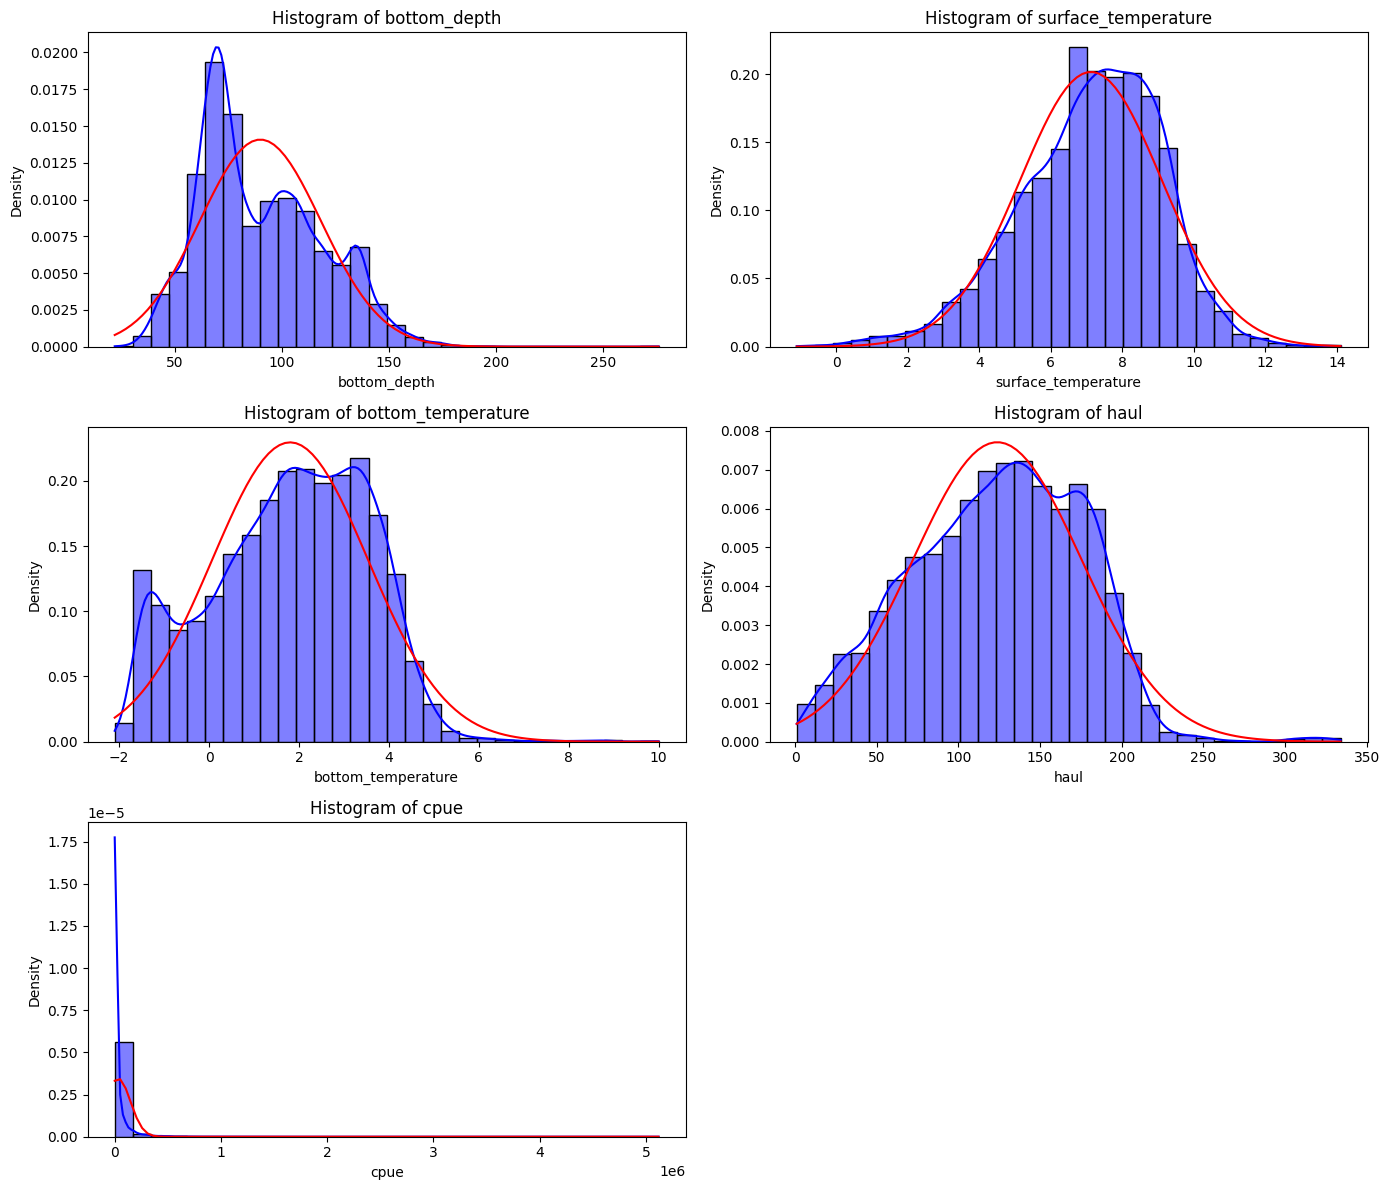

In [10]:
columns_to_plot = ['bottom_depth', 'surface_temperature', 'bottom_temperature', 'haul', 'cpue']

# Set up a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()  # Flatten so you can index easily

# Loop through columns and axes
for i, col in enumerate(columns_to_plot):
    data = crab_df[col].dropna()

    # Plot histogram with seaborn's histplot (automatically fits a normal distribution)
    sns.histplot(data, kde=True, ax=axes[i], color='blue', stat='density', bins=30)
    
    mu = np.mean(data)
    std = np.std(data)

    x = np.linspace(min(data), max(data), 100)
    normal_dis = stats.norm.pdf(x, mu, std)
    axes[i].plot(x, normal_dis, color='red', label='Normal Distribution')


    # Titles and labels
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Hide the last subplot if not used
if len(columns_to_plot) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [11]:
year_crab_df = crab_df.groupby("year").mean(numeric_only=True)
year_crab_df.sample(10).sort_index()
year_crab_df.columns[2:]

Index(['longitude', 'bottom_depth', 'surface_temperature',
       'bottom_temperature', 'haul', 'cpue'],
      dtype='object')

Index(['bottom_depth', 'surface_temperature', 'bottom_temperature', 'haul',
       'cpue'],
      dtype='object')


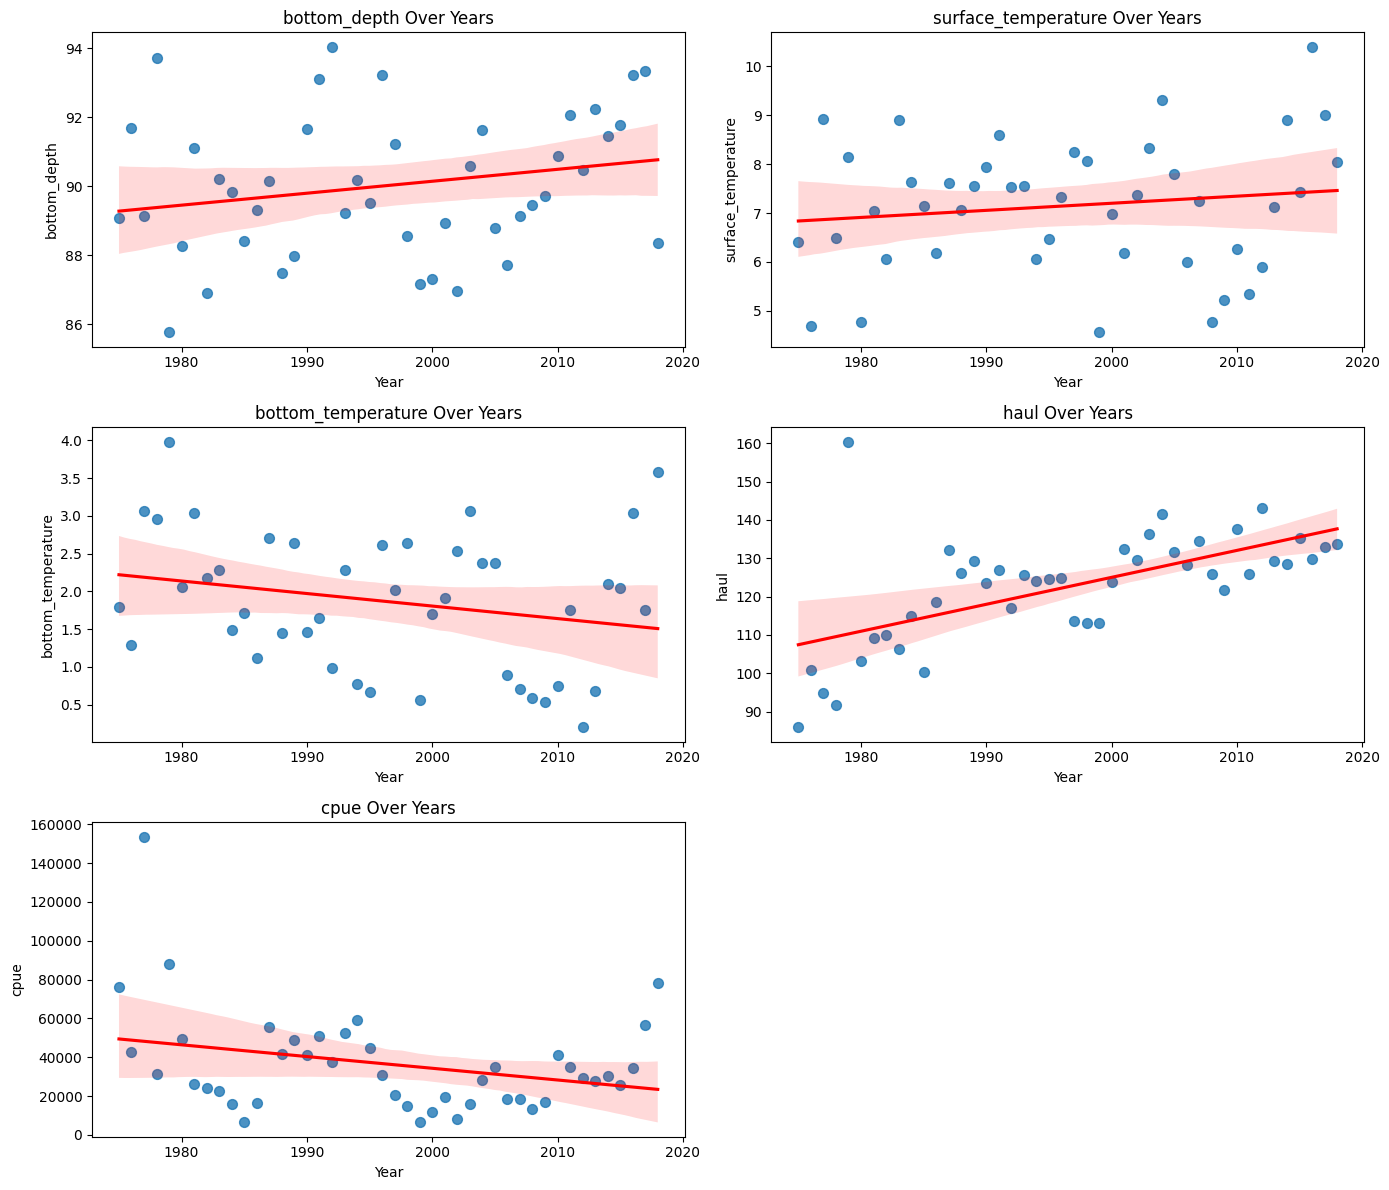

In [12]:
columns_to_plot = year_crab_df.columns[3:]  # assuming columns 0 and 1 are lat/lon
year_crab_df.index = pd.to_numeric(year_crab_df.index, errors='coerce')
print(columns_to_plot)

fig, axes = plt.subplots(3,2, figsize=(14,12))
axes = axes.flatten()


for i, col in enumerate(columns_to_plot):
    sns.regplot(x=year_crab_df.index, y=year_crab_df[col], ax=axes[i], 
                scatter_kws={'s': 50}, line_kws={'color': 'red'}, ci=95)
    axes[i].set_title(f"{col} Over Years")
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(f"{col}")
    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

So we see that the haul is going up but is that because there are more occurences in later years or are they really catching more crabs per trip later on?
cpue is the Catch Per Unit Effort which is what we need to investigate further

In [13]:
first_years = crab_df[crab_df['year'].isin([1975, 1976])]
last_years = crab_df[crab_df['year'].isin([2017,2018])]

print(f"Number of Records First Two Years: {len(first_years)}")
print(f"Average Catch Per Effor first years: {first_years['cpue'].mean()}")
print(f"Number of Records Last two Years: {len(last_years)}")
print(f"Average Catch Per Effort Last Years: {last_years['cpue'].mean()}")

Number of Records First Two Years: 378
Average Catch Per Effor first years: 59073.98148148148
Number of Records Last two Years: 769
Average Catch Per Effort Last Years: 67418.1144343303


There was 935 more efforts last 5 years compared to the first 5
There was 24817.34 more crabs caught per effort in the first 5 years than the last 5 years
There was 12870955 more total crabs caught in the last five years though


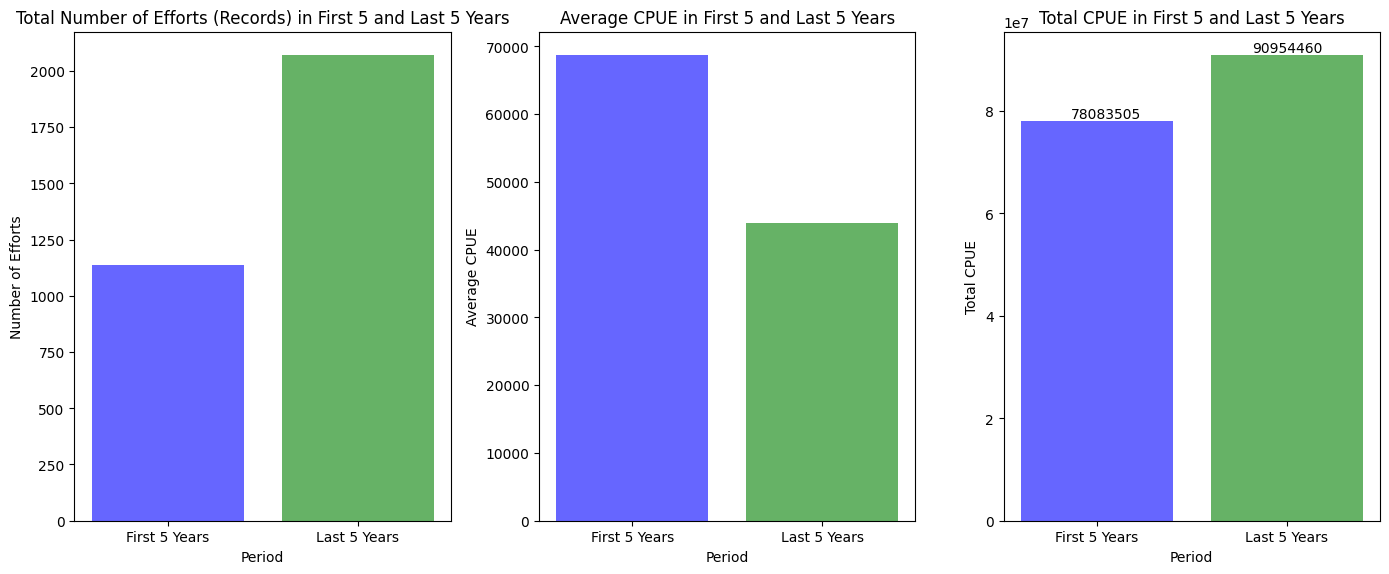

In [14]:
# First Plot - Number of Efforts (Records)
first_5_years = crab_df[crab_df['year'].isin([1975, 1976, 1977, 1978, 1979])]
last_5_years = crab_df[crab_df['year'].isin([2014, 2015, 2016, 2017, 2018])]

# Create the subplot grid (1 row, 2 columns)
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

total_efforts_first_5 = int(len(first_5_years))
total_efforts_last_5 = int(len(last_5_years))
print(f"There was {total_efforts_last_5 - total_efforts_first_5} more efforts last 5 years compared to the first 5")

# Calculate the overall average CPUE for the first 5 years and last 5 years
avg_cpue_first_5 = round(float(first_5_years['cpue'].mean()), 2)
avg_cpue_last_5 = round(float(last_5_years['cpue'].mean()), 2)
print(f"There was {np.round(avg_cpue_first_5 - avg_cpue_last_5, 2)} more crabs caught per effort in the first 5 years than the last 5 years")

total_cpue_first_5 = first_5_years['cpue'].sum()
total_cpue_last_5 = last_5_years['cpue'].sum()
print(f"There was {total_cpue_last_5 - total_cpue_first_5} more total crabs caught in the last five years though")
# First Plot - Number of Efforts (Records) for First 5 and Last 5 Years
axes[0].bar(['First 5 Years', 'Last 5 Years'], [total_efforts_first_5, total_efforts_last_5], color=['blue', 'green'], alpha=0.6)
axes[0].set_title('Total Number of Efforts (Records) in First 5 and Last 5 Years')
axes[0].set_xlabel('Period')
axes[0].set_ylabel('Number of Efforts')

# Second Plot - Average CPUE for First 5 and Last 5 Years
axes[1].bar(['First 5 Years', 'Last 5 Years'], [avg_cpue_first_5, avg_cpue_last_5], color=['blue', 'green'], alpha=0.6)
axes[1].set_title('Average CPUE in First 5 and Last 5 Years')
axes[1].set_xlabel('Period')
axes[1].set_ylabel('Average CPUE')

axes[2].bar(['First 5 Years', 'Last 5 Years'], [total_cpue_first_5, total_cpue_last_5], color=['blue', 'green'], alpha=.6)
axes[2].set_title('Total CPUE in First 5 and Last 5 Years')
axes[2].set_xlabel('Period')
axes[2].set_ylabel('Total CPUE')
axes[2].set_yscale('linear')
axes[2].text(0.05, total_cpue_first_5, int(total_cpue_first_5), ha='center', va='bottom', color='black', fontsize=10)
axes[2].text(1, total_cpue_last_5,int(total_cpue_last_5), ha='center', va='bottom', color='black', fontsize=10)
# Adjust layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()

In [15]:
crab_df['lat_round'] = crab_df['latitude'].round(2)  # Round latitude for grouping
crab_df['lon_round'] = crab_df['longitude'].round(2)  # Round longitude for grouping
# Group by rounded latitude and longitude, then take the mean of 'cpue_scaled_global'
aggregated_df = crab_df.groupby(['lat_round', 'lon_round', 'year'], as_index=False)['cpue'].mean()
zmin = aggregated_df['cpue'].min()
zmax = aggregated_df['cpue'].max()

In [21]:
fig = px.density_mapbox(crab_df, lat='latitude', lon='longitude', z='cpue', radius=40, center=dict(lat=crab_df.latitude.mean(), 
                        lon=crab_df.longitude.mean()), zoom=4, mapbox_style='open-street-map', height=600, width=600,
                        animation_frame='year', range_color=[zmin, zmax])
fig.show()

In [20]:
fig.write_html("crab_cpue_map.html")